In [59]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from operator import add
from tqdm import notebook
from time import time

The simulation has 3 different steps: 1. simulate the desiered signal to try to detect 2. use a ME simulation to gennerate a detection record 3. use desiered technique to estimate the simulated signal

## Global perameters

In [60]:
N_states = 2 # number of different singnal states
t_gamma = 1500 # time of the simulation
gamma = 2 # characteristic decay rate
t = t_gamma / gamma # time of the simulation
dt = 0.003 # time step of the simulation
N_t = int(t / dt + 1) # number of time steps
times = np.linspace(0, t, N_t, endpoint=True) # time steps
seed_signal = 26 # seed for random number generator for the signal
seed_simulation = 8 # seed for random number generator for the simulation
t_signal_leadin = 1 # time for the stocastic nature of the signal to not be at 0 as the begining of the simulation
gamma_decay = gamma # decay rate of qubit out of cavity
gamma_phi = gamma # dephasing rate of qubit
Delta_n_min, Delta_n_max = -2 * gamma, 2 * gamma # range of the signal strengths
p = 0.02 * gamma # transition rate 







## Usefull functions

In [61]:
gamma_purcell = lambda Delta_n : 2 * g ** 2 * kappa / (kappa ** 2 + (Delta_r - Delta_n) ** 2)


# 1. Simulating the signal

The signal system i want to look at is a simple Hidden Markov Model, with 3 states, -1 $\gamma$, 0 and 1 $\gamma$ for the magnetic field affacting the spin. 

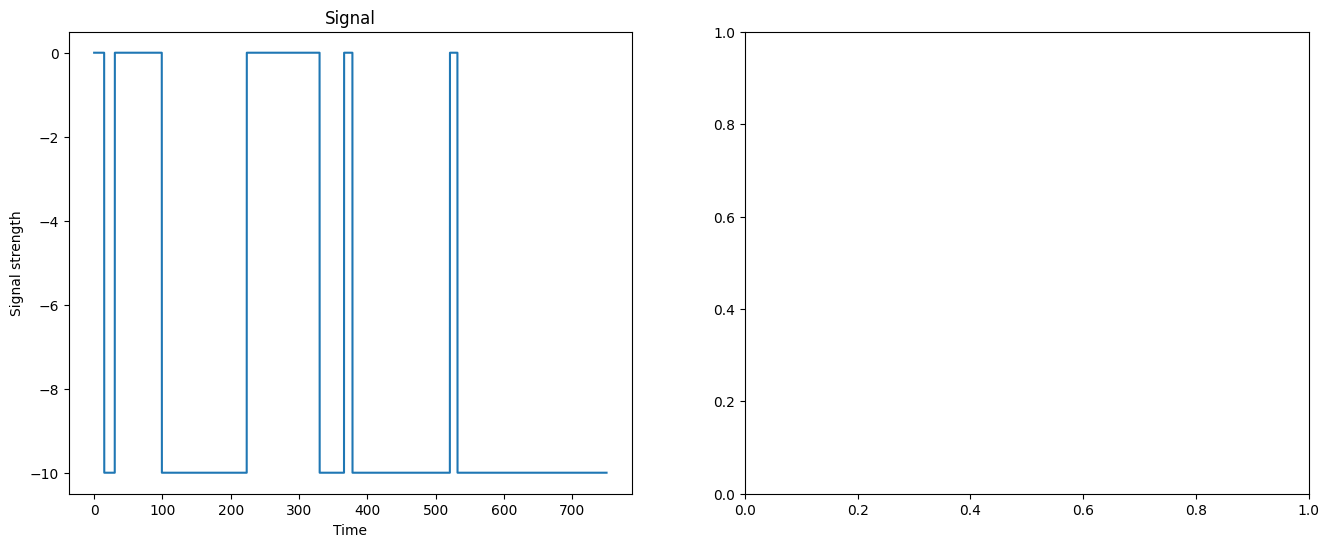

In [62]:
r_signal = np.random.default_rng(seed_signal) # random number generator for the signal
N_t_leadin = int(t_signal_leadin / dt) # number of time steps for the leadin of the signal



B = np.zeros(N_t_leadin + N_t, dtype=int) # signal strength
B_state = np.zeros(N_t_leadin + N_t, dtype=int) # state of the HMM

B_field_strength = 5

B_signal_stegths = (np.arange(N_states) - N_states / 2) * B_field_strength # posible signal strengths



st = 0.01 # to regulate the transtion rate between HMM states

def gennerate_r_next_neighbour_jump(N, st):
    r = np.eye(N, k=0) * (1 - 2 * st)
    r += np.eye(N, k=1) * st
    r += np.eye(N, k=-1) * st
    r[0, 0] = 1 - st
    r[-1, -1] = 1 - st
    return r

r_HMM = gennerate_r_next_neighbour_jump(N_states, st)


#col = plt.imshow(r_HMM, vmin=0, vmax=1)

#plt.colorbar(col)
#plt.show()

#r_HMM = np.array([[1 - 0.2 * st, 0.2 * st],
#                  [0.2 * st, 1 - 0.2 * st]]) # transition matrix of the HMM

#r_HMM = np.array([[1, 0],
#                  [0, 1]]) # transition matrix of the HMM





B_state[0] = int(N_states / 2)  # initial state of the HMM
B[0] = B_signal_stegths[B_state[0]] # initial signal strength





r_HMM_sim = np.zeros((N_states, N_states))

for i in range(N_states):
    for j in range(N_states):
        if i != j:
            r_HMM_sim[i, j] = r_HMM[i, j] * dt

for i in range(N_states):
    r_HMM_sim[i, i] = 1 - np.sum(r_HMM_sim[i, :])




# generate the signal
for i in range(1, N_t_leadin + N_t):
    q = r_signal.random()
    prob_sum = 0
    nr = 0
    while prob_sum < q:
        prob_sum += r_HMM_sim[B_state[i - 1], nr]
        nr += 1
    B[i] = B_signal_stegths[nr - 1]
    B_state[i] = nr - 1

    



B_new = B[N_t_leadin:] # remove the leadin of the signal
B_state_new = B_state[N_t_leadin:] # remove the leadin of the signal
#dW = dW[N_t_leadin:] # remove the leadin of the Wiener process
Delta_n = B_new * gamma # signal, rounded to the nearest integer as the ME simulationonly works for a descrete set of signal strengths

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

t_plot = np.linspace(0, t, N_t)

ax[0].plot(t_plot, Delta_n)
ax[0].set_title('Signal')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal strength')

#ax[1].set_title('Wiener process')
#ax[1].plot(t_plot, dW)

plt.show()



# 2. Simulate detection record

In [63]:
kappa = 10 * gamma # amplitude decay rate of cavity field due to transmission of the output field
kappa_1 = kappa # amplitude decay rate of cavity field due to loss
Delta_r = 0 # cavity detuning
g = 5 * gamma # coupling strength
beta = np.sqrt(gamma) # amplitude of driving field
alpha = np.sqrt(2 * kappa) * beta / (kappa + 1j * Delta_r)
epsilon_n = g ** 2 * (Delta_r - Delta_n) / (kappa ** 2 + (Delta_r - Delta_n)** 2)

epsilon_n = epsilon_n.tolist()



sigma_z = qt.sigmaz() # Pauli-Z operator for qubit
sigma_p = qt.sigmap() # raising operator for qubit
sigma_m = qt.sigmam() # lowering operator for qubit


c_1 = qt.QobjEvo([sigma_m, lambda t : np.sqrt(gamma_purcell(Delta_n[int(t/dt)])).tolist()])
c_2 = np.sqrt(gamma_decay) * sigma_m # decay of qubit out of the cavity
c_3 = np.sqrt(gamma_phi / 2) * sigma_z # dephasing of qubit



c_out_part_1 = qt.QobjEvo([sigma_m, lambda t : 1j * g / (kappa + 1j * (Delta_r - Delta_n[int(t/dt)]))])

c_out = np.sqrt(2 * kappa_1) * (alpha - c_out_part_1) - beta




rho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag() # density matrix of the qubit

H_1 = qt.QobjEvo([sigma_z, lambda t : Delta_n[int(t/dt)] / 2])

H_2 = qt.QobjEvo([sigma_p * sigma_m, lambda t : epsilon_n[int(t/dt)]])

H = H_1 + g * (alpha  * sigma_p + np.conjugate(alpha) * sigma_m) - H_2



To get a detection record, one will need to use the stocastic masterequation solver smesolve, and include the argument {"store_measurement": True}. The default measurment methode is homodyne detection, hetrodyne detection is also posible. c_ops is the lindbald colaps oporators, sc_ops is the stocastic colaps oporators, and e_ops is the oporator witch the expectation value will be saved

# 3. Estimate signal

As the system is subject to homodyne dectection, then the system evolves after a stocastic master equation 
$$\tilde{\rho}(t + dt) = \tilde{\rho}(t) +d\tilde{\rho}$$ 
where 
$ $d\tilde{\rho}=L\tilde{\rho}dt + \chi_\phi \tilde{\rho}dY_t $$
Where $dY_t$ is the detection record. To be able to accomidate the HMM, we will exted the hilbert space to include the HHM states so 
$$ \tilde{\rho} = \Sigma_n\tilde{\rho}_n \otimes \ket{n} \bra{n} $$, 
and 
$$ \chi_\phi = \sqrt{\nu}(\hat{c}_{out}e^{-i\phi}\rho - \rho \hat{c}^\dag _{out}e^{i\phi}) $$
with coresponding Lindblad oporators 
$$\hat{J}_{nn'}=\sqrt{r_{nn'}}\ket{n'}\bra{n}$$. 
The goal is to predict the HMM state n, and the probability of being in state n is 
$$P_n(t)=\textrm{Tr}[\rho_n(t)]$$
to normelize $\tilde{\rho}_n$ to get $\rho_n$ this is done by 
$$\rho_n = \frac{\tilde{\rho}_n}{\textrm{Tr}(\tilde{\rho})}$$
As the new Hilbert space is bigger, we need to redefine all of our oporators and the hamiltonian. for most oporators that dont depend on the state of the HMM this i suficent 
$$\hat{a}_{new}= a \otimes I_{N+1}$$
but of oporator witch are dependent on the HMM state, then inseted of the identity a diagonelized array of the diferent coeficents for the states will be used
The transition rate $r_{nn'}$ have to be given, and scice the state of the HMM only can change to the naigboring states, then $r_{nn'}$ is an matrix with non 0 on the 2 closest offdiagonals




Now that we have a detection record, it can be inserted on the stocastic dW place. The thing is that the output signal is $ Tr(c_{out} \rho c_{out}^\dag) + dw$.

In [64]:
rho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag() # density matrix of the qubit
rho_n = 1/N_states * qt.basis(N_states, 0) * qt.basis(N_states, 0).dag() # density matrix of HMM states
for i in range(1, N_states):
    rho_n += 1/N_states * qt.basis(N_states, i) * qt.basis(N_states, i).dag() # density matrix of HMM states
rho_HMM = qt.tensor(rho_0, rho_n) # density matrix of the qubit and HMM

I_n = qt.qeye(N_states) # identity operator for the HMM

sigma_z_HMM = qt.tensor(sigma_z, I_n) # Pauli-Z operator for qubit
sigma_p_HMM = qt.tensor(sigma_p, I_n) # raising operator for qubit
sigma_m_HMM = qt.tensor(sigma_m, I_n) # lowering operator for qubit


Delta_n_posible = B_signal_stegths * gamma # possible signal strengths

epsilon_n_posible = g ** 2 * (Delta_r - Delta_n_posible) / (kappa ** 2 + (Delta_r - Delta_n_posible) ** 2) # possible epsilon strengths

c_1_HMM = qt.tensor(1 / 2 * sigma_m, qt.qdiags(np.sqrt(gamma_purcell(Delta_n_posible))))
c_2_HMM = np.sqrt(gamma_decay) * sigma_m_HMM # decay of qubit out of the cavity
c_3_HMM = np.sqrt(gamma_phi / 2) * sigma_z_HMM # dephasing of qubit


c_out_part_1 = qt.tensor(qt.qdiags(1j * g / (kappa + 1j * (Delta_r - Delta_n_posible))), sigma_m)

c_out_HMM = np.sqrt(2 * kappa_1) * (alpha - c_out_part_1) - beta


H_1_HMM = qt.tensor(sigma_z, qt.qdiags(Delta_n_posible / 2))
sigma_p * sigma_m * epsilon_n[i]
H_2_HMM = qt.tensor(sigma_p * sigma_m, qt.qdiags(epsilon_n_posible))

H_HMM = H_1_HMM + g * (alpha  * sigma_p_HMM + np.conjugate(alpha) * sigma_m_HMM) - H_2_HMM


### jump oporators for the HMM states

r_HMM_jump = r_HMM_sim.copy()
r_HMM_jump = r_HMM_jump - np.eye(len(B_signal_stegths)) * np.diag(r_HMM_jump) # remove the diagonal elements
#r = p * np.eye(N+1, k=-1) + np.eye(N+1, k=1) # transition matrix of the HMM
J_HMM_list = []
    
for i in range(N_states):
    for j in range(N_states):
        if r_HMM_jump[i, j] != 0:
            J_HMM_list.append(qt.tensor(qt.qeye(2), np.sqrt(r_HMM_jump[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag()))
    


B_state_oporator = qt.tensor(qt.qdiags(B_signal_stegths), qt.qeye(2))



# My own solver

In [65]:
class PQSSolver:
    def __init__(self, H, rho_0, times, c_ops, sc_ops, e_ops, phi=0, detector_effecency=None, timedependent_H=False):
        self.H = H
        self.rho_0 = rho_0
        self.system_size = int(rho_0.shape[0] / N_states)
        self.times = times
        self.N_t = len(times)
        self.dt = times[1] - times[0]
        self.index = 0
        self.c_ops = c_ops
        self.c_ops_numbers = len(c_ops)
        self.sc_ops = sc_ops
        self.sc_ops_numbers = len(sc_ops)
        self.rho = []#np.zeros((self.N_t, *np.shape(rho_0)), dtype=complex)
        self.rho.append(self.rho_0)
        self.phi = phi
        self.expectation = np.zeros((len(e_ops), self.N_t), dtype=complex)
        self.e_ops = e_ops
        self.e_ops_numbers = len(e_ops)
        self.timedependent_H = timedependent_H
        self.measurment = False

        if detector_effecency == None:
            self.nu = np.ones(self.sc_ops_numbers)
        else:
            self.nu = detector_effecency
        
    def expectation_value(self, c, rho):
        """Calculates the expectation value of the output oporator"""

        expectation = ((c * rho)).tr()
        return expectation
    
    def variance_oporator(self, c, rho):
        """Calculates the variance of the output oporator"""
        variance = self.expectation_value((c + c.dag()) ** 2, rho) - self.expectation_value(c + c.dag(), rho) ** 2
        return variance

    def D_operator(self, c, rho):
        """Calculates the D superoperator, witch is the linblad dissipation terms"""
        D = c * rho * c.dag() - 1 / 2 * (c.dag() * c * rho + rho * c.dag() * c)
        return D
    
    def D_operator_dag(self, c, E):
        """Calculates the D superoperator, witch is the linblad dissipation terms"""
        D = c.dag() * E * c - 1 / 2 * (c.dag() * c * E + E * c.dag() * c)
        return D
    
    def lindblad_terms(self, rho, oporators, oporator_number, index):
        """Calculates the lindblad operator"""

        lindblad = 0
        if self.timedependent_H:
            for i in range(oporator_number):
                lindblad += self.D_operator(oporators[i][index], rho)
        
        else:
            for i in range(oporator_number):
                lindblad += self.D_operator(oporators[i], rho)

        return lindblad
    
    def lindblad_terms_dag(self, E, oporators, oporator_number, index):
        """Calculates the lindblad operator"""

        lindblad = 0
        if self.timedependent_H:
            for i in range(oporator_number):
                lindblad += self.D_operator_dag(oporators[i][index], E)
        
        else:
            for i in range(len(oporators)):
                lindblad += self.D_operator_dag(oporators[i], E)

        return lindblad
    
    def H_operator(self, c, rho):
        """Calculates the H superoperator, witch is the superoporator for the backaction of the measurement"""

        H = c * rho + rho * c.dag() - self.expectation_value(c + c.dag(), rho) * rho
        return H
    
    def H_operator_dag(self, c, E):
        """Calculates the H superoperator, witch is the superoporator for the backaction of the measurement"""

        H = c.dag() * E + E * c - self.expectation_value((c + c.dag()).dag(), E) * E
        return H
    
    def backaction_terms(self, rho, index, dw):
        """Calculates the backaction of the measurements"""

        backaction = 0
        if self.timedependent_H:
            for i in range(self.sc_ops_numbers):
                backaction += self.H_operator(self.sc_ops[i][index], rho) * dw[i, index]
        
        else:
            for i in range(self.sc_ops_numbers):
                backaction += self.H_operator(self.sc_ops[i], rho) * dw[i, index]        


        return backaction
    

    def backaction_terms_dag(self, E, index, index_reverse, dw):
        """Calculates the backaction of the measurements"""

        backaction = 0
        if self.timedependent_H:
            for i in range(self.sc_ops_numbers):
                backaction += self.H_operator_dag(self.sc_ops[i][index_reverse], E) * dw[i, index]
        
        else:
            for i in range(self.sc_ops_numbers):
                backaction += self.H_operator_dag(self.sc_ops[i], E) * dw[i, index]        


        return backaction
    


    
        
    def func_homodyne(self, index, rho, dw):
        """The function to be solved"""

        if self.timedependent_H:
            Hamiltion_term = - 1j * (self.H[index] * rho - rho * self.H[index]) * self.dt
            lindblad_contribution = self.lindblad_terms(rho, self.c_ops, self.c_ops_numbers, index) * self.dt
            measurment_backaction = self.lindblad_terms(rho, self.sc_ops, self.sc_ops_numbers, index) * self.dt + self.backaction_terms(rho, index, dw)
        else:
            Hamiltion_term = - 1j * (self.H * rho - rho * self.H) * self.dt
            lindblad_contribution = self.lindblad_terms(rho, self.c_ops, self.c_ops_numbers, index) * self.dt
            measurment_backaction = self.lindblad_terms(rho, self.sc_ops, self.sc_ops_numbers, index) * self.dt + self.backaction_terms(rho, index, dw)


        return Hamiltion_term + lindblad_contribution + measurment_backaction
    

    def calculate_Adam_Bashforth_coeficents(self, order):
        """Calculates the coeficents for the Adam Bashforth methode"""
        coeficents = np.zeros(order)
        if order == 1:
            coeficents = np.array([1])
        elif order == 2:
            coeficents = np.array([3/2, -1/2])
        elif order == 3:
            coeficents = np.array([23/12, -4/3, 5/12])
        elif order == 4:
            coeficents = np.array([55/24, -59/24, 37/24, -3/8])
        elif order == 5:
            coeficents = np.array([1901/720, -1387/360, 109/30, -637/360, 251/720])
        elif order == 6:
            coeficents = np.array([4277/1440, -2641/480, 4991/720, -3649/720, 959/480, -95/288])
        elif order == 7:
            coeficents = np.array([198721/60480, -18637/2520, 235183/20160, -10754/945, 135713/20160, -5603/2520, 19087/60480])
        elif order == 8:
            coeficents = np.array([16083/4480, -1152169/120960, 242653/13440, -296053/13440, 2102243/120960, -115747/13440, 32863/13440, -5257/17280])
        elif order == 9:
            coeficents = np.array([2171465/725760, -13486539/362880, 479101/8064, -7179867/120960, 11295603/362880, -12203/1512, 25713/4480, -227/504, 1/10])
        return coeficents

    def Adam_Bashforth_next_step_homodyne(self, dw, index, order):
        """Calculates the next values with the Adam Bashforth methode"""
        
        order = min(order, index + 1)
        coeficents = self.calculate_Adam_Bashforth_coeficents(order)
        d_rho = coeficents[0] * self.func_homodyne(index, self.rho[index], dw) 
        

        for i in range(1, order):
            d_rho += coeficents[i] * self.func_homodyne(index - i, self.rho[index - i], dw)

        return d_rho

        


    def Euler_next_step_homodyne(self, dw, index):
        """Calculates the next values with the Euler methode"""
        
        d_rho = self.func_homodyne(index, self.rho[index], dw)
        
        return d_rho

    def next_step_homodyne(self, dw, index, methode='Euler', order=1):
        """Calculates the next values with the given methode"""

        if methode == 'Euler':
            d_rho = self.Euler_next_step_homodyne(dw, index)
        elif methode == 'Adam Bashforth':
            d_rho = self.Adam_Bashforth_next_step_homodyne(dw, index, order)

        #print(d_rho)

        rho_new = self.rho[index] + d_rho
        rho_new = rho_new / rho_new.tr()
        self.rho.append(rho_new)


    def calculate_expectation_values(self, rho, index):
        """Calculates the expectation value of the output oporator"""
        
        if self.timedependent_H:
            for i in range(len(self.e_ops)):
                self.expectation[i][index] = self.expectation_value(self.e_ops[i][index], rho[index])

        else:
            for i in range(len(self.e_ops)):
                self.expectation[i][index] = self.expectation_value(self.e_ops[i], rho[index])
    

        




class Experiment_simulation(PQSSolver):
    def __init__(self, H, rho_0, times, c_ops, sc_ops, e_ops, phi=0, detector_effecency=None, timedependent_H=False):
        super().__init__(H, rho_0, times, c_ops, sc_ops, e_ops, phi, detector_effecency, timedependent_H)

    def gennerate_outputsignal(self, dw, rho, c, nu):
        """Calculates the output signal of the homodyne detection from stocastic dw"""
        dY = np.sqrt(nu) * dw + nu * self.expectation_value(c + c.dag(), rho) * self.dt
        return dY

    def gennerate_dw(self, noise_factor=1):
        """Generates the stocastic dw"""
        dw = np.random.normal(0, np.sqrt(self.dt) * noise_factor, (self.sc_ops_numbers, self.N_t))
        return dw

    def solve_homodyne(self, methode='Euler', noise_factor=1, order=1):
        """Solves the stocastic master equation with homodyne detection"""

        
        dw = self.gennerate_dw(noise_factor)
            
        dY = np.zeros((self.sc_ops_numbers, self.N_t))
        
        for index in notebook.tqdm(range(self.N_t)):
            for i in range(self.sc_ops_numbers):
                dY[i][index] = self.gennerate_outputsignal(dw[i][index], self.rho[index], self.sc_ops[i][index], self.nu[i])
            self.next_step_homodyne(dw, index, methode=methode, order=order)
            self.calculate_expectation_values(self.rho, index)

        self.detection_record = dY
        


class Experiment_estimation(PQSSolver):
    def __init__(self, H, rho_0, times, c_ops, sc_ops, N_states, e_ops, phi=0, detector_effecency=None, timedependent_H=False):
        super().__init__(H, rho_0, times, c_ops, sc_ops, e_ops, phi, detector_effecency, timedependent_H)
        self.N_states = N_states
        self.P_n_rho = np.zeros((self.N_t, self.N_states), dtype=complex)
        self.P_n_E = np.zeros((self.N_t, self.N_states), dtype=complex)
        self.P_n_PQS = np.zeros((self.N_t, self.N_states), dtype=complex)
        
    def func_homodyne_E(self, index, index_reverse, E, dw):
        """The function to be solved"""

        if self.timedependent_H:
            Hamiltion_term = 1j * (self.H[index_reverse] * E - E * self.H[index_reverse]) * self.dt
        
            lindblad_contribution = self.lindblad_terms_dag(E, self.c_ops, self.c_ops_numbers, index_reverse) * self.dt
            measurment_backaction = self.lindblad_terms_dag(E, self.sc_ops, self.sc_ops_numbers, index_reverse) * self.dt + self.backaction_terms_dag(E, index, index_reverse, dw)
            
        else:
            Hamiltion_term = 1j * (self.H * E - E * self.H) * self.dt
            lindblad_contribution = self.lindblad_terms_dag(E, self.c_ops, self.c_ops_numbers, index_reverse) * self.dt
            measurment_backaction = self.lindblad_terms_dag(E, self.sc_ops, self.sc_ops_numbers, index_reverse) * self.dt + self.backaction_terms_dag(E, index, index_reverse, dw)

        

        return Hamiltion_term + lindblad_contribution + measurment_backaction

    def solve_homodyne(self, dY, methode='Euler', order=1):
        """Solves the stocastic master equation with homodyne detection"""
                
        dv = np.zeros((self.sc_ops_numbers, self.N_t)) # it is denoted dv as it is the estimate of the winer increment dw
        
        for index in notebook.tqdm(range(self.N_t)):
            for i in range(self.sc_ops_numbers):
                dv[i][index] = self.estimate_dw(dY[i][index], self.rho[index], self.sc_ops[i], self.nu[i])
            self.next_step_homodyne(dv, index, methode=methode, order=order)
            self.calculate_expectation_values(self.rho, index)
            self.probability_rho(index)
        
        
        self.dv_rho = dv

        self.detection_record = dY

    def next_step_homodyne_E(self, dw, index, index_reverse, methode='Euler', order=1):
        """Calculates the next values with the given methode"""

        if methode == 'Euler':
            d_E = self.func_homodyne_E(index, index_reverse, self.E[index], dw)
        elif methode == 'Adam Bashforth':
            d_E = self.Adam_Bashforth_next_step_homodyne_E(dw, index, index_reverse, order)

        self.dp_0.append(self.extract_E_n(d_E, 0).tr())
        self.dp_1.append(self.extract_E_n(d_E, 1).tr())

        E_new = self.E[index] + d_E
        E_new = E_new / E_new.tr()
        self.E.append(E_new)

    def Euler_next_step_homodyne_E(self, dw, index, index_reverse):
        """Calculates the next values with the Euler methode"""

        d_E = self.func_homodyne_E(index, index_reverse, self.E[index], dw)
        
        return d_E
        
    def Adam_Bashforth_next_step_homodyne_E(self, dw, index, index_reverse, order):
        """Calculates the next values with the Adam Bashforth methode"""
        
        order = min(order, index)

        d_E = self.func_homodyne_E(index, index_reverse, self.E[index], dw)
        coeficents = self.calculate_Adam_Bashforth_coeficents(order)

        for i in range(1, order):
            d_E += coeficents[i] * self.func_homodyne_E(index - i, index_reverse - i, self.E[index - i], dw)

        return d_E

    def extract_rho_n(self, rho, n):
        """Extracts the density matrix of the qubit from the density matrix of the qubit and HMM"""

        if self.N_states == 1:
            return rho

        rho_n_op = qt.tensor(qt.basis(self.N_states, n) * qt.basis(self.N_states, n).dag(), qt.qeye(2))
        rho_n = rho * rho_n_op
        return rho_n
    
    def extract_E_n(self, E, n):
        """Extracts the E of the qubit from the E matrix of the qubit and HMM"""

        if self.N_states == 1:
            return E
        E_n_op = qt.tensor(qt.basis(self.N_states, n) * qt.basis(self.N_states, n).dag(), qt.qeye(2))
        E_n = E_n_op * E
        return E_n
    
    def probability_rho(self, index):
        """Calculates the probability of the HMM states given the density matrix"""
        for i in range(self.N_states):
            p_n = (self.extract_rho_n(self.rho[index], i)).tr()
            self.P_n_rho[index, i] = p_n
    
    def probability_E(self, index):
        """Calculates the probability of the HMM states given the effects matrix"""
        for i in range(self.N_states):
            p_n = (self.extract_E_n(self.E[index], i)).tr()
            self.P_n_E[index, i] = p_n 
    
    def probability_PQS(self, index):
        """Calculates the probability of the HMM states given both the density and effects matrix"""

        for i in range(self.N_states):
            p_n = (self.extract_rho_n(self.rho[index], i) * self.extract_E_n(self.E[index], i)).tr()
            self.P_n_PQS[index, i] = p_n
        norm_factor = np.sum(self.P_n_PQS[index])
        self.P_n_PQS[index] = self.P_n_PQS[index] / norm_factor

    def estimate_dw(self, dY, rho, c, nu):
        """Calculates the estimate of the stocastic dw from the output signal"""
        dw = dY / np.sqrt(nu) - np.sqrt(nu) * self.expectation_value(c + c.dag(), rho) * self.dt
        return dw

    def solve_homodyne_E(self, dY, methode='Euler', order=1):
        """Solves the stocastic master equation for the effect matrix with detection"""
        # The signal type should always be full, as it is only relevant when estimating
        
        self.E = []
        self.E.append(qt.tensor(qt.qeye(self.N_states), qt.qeye(self.system_size)))
        self.E[0] = self.E[0] / self.E[0].tr()
        self.dp_0 = []
        self.dp_1 = []

        dv = np.zeros((self.sc_ops_numbers, self.N_t)) # it is denoted dv as it is the estimate of the winer increment dw
        for index in notebook.tqdm(range(self.N_t)): # Be aware that here we are indexing backwards in time, 
            index_reverse = self.N_t - index - 1 # it is E and dv that are indexed backwards in time, so all the other tings use index_reverse
            for i in range(self.sc_ops_numbers):
                dv[i][index] = self.estimate_dw(dY[i][index_reverse], self.E[index], self.sc_ops[i], self.nu[i]) # do I need rho for the estimate?
            self.next_step_homodyne_E(dv, index, index_reverse, methode=methode, order=order)

        
        self.E = self.E[::-1] # reverse the list to get the correct order of the elements
        self.dv_E = np.flip(dv, axis=1) # reverse the list to get the correct order of the elements
        self.dp_0 = self.dp_0[::-1]
        self.dp_1 = self.dp_1[::-1]

                
        for index in range(self.N_t):
            self.probability_E(index)

    def solve_PQS(self, dY, methode='Euler', order=1):
        """Solves the stocastic master equation for the density matrix and the effects matrix with detection record"""

        self.solve_homodyne(dY, methode=methode, order=order)
        self.solve_homodyne_E(dY, methode=methode, order=order)

        
        for index in notebook.tqdm(range(self.N_t)):
            self.probability_PQS(index)

    






## Gennerating the detection record

In [66]:
#N = 1

#noise_factor = 0.004
noise_factor = 1

c_1 = [sigma_m * np.sqrt(gamma_purcell(Delta_n[i])) for i in range(N_t)]
c_2 = [np.sqrt(gamma_decay) * sigma_m for i in range(N_t)] # decay of qubit out of the cavity
c_3 = [np.sqrt(gamma_phi / 2) * sigma_z for i in range(N_t)] # dephasing of qubit
c_out = [np.sqrt(2 * kappa_1) * (alpha - sigma_m * 1j * g / (kappa + 1j * (Delta_r - Delta_n[i]))) - beta for i in range(N_t)]
c_out_dag = [np.sqrt(2 * kappa_1) * (alpha + sigma_p * 1j * g / (kappa - 1j * (Delta_r - Delta_n[i]))) - beta for i in range(N_t)]





c_ops_1 = [c_1, c_2, c_3] 
rho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag()





#H_1 = qt.QobjEvo([sigma_z, lambda t : Delta_n[int(t/dt)] / 2])

#H_2 = qt.QobjEvo([sigma_p * sigma_m, lambda t : epsilon_n[int(t/dt)]])

H_pqs = [sigma_z * Delta_n[i] / 2  + g * (alpha  * sigma_p + np.conjugate(alpha) * sigma_m) - sigma_p * sigma_m * epsilon_n[i] for i in range(N_t)]
#H_pqs_2 = [sigma_p * sigma_m * epsilon_n[i] for i in range(N_t)]


#H_pqs_1 = sigma_z * Delta_n / 2
#H_pqs_2 = sigma_p * sigma_m * epsilon_n
#H_pqs = H_pqs_1 + g * (alpha  * sigma_p + np.conjugate(alpha) * sigma_m) - H_pqs_2

e_ops_list = [list(map(add, c_out, c_out_dag))]

PQS = Experiment_simulation(H_pqs, rho_0, times, c_ops_1, [c_out], e_ops=e_ops_list, timedependent_H=True) # not very elegant that one need to write the 1 at N_states
PQS.solve_homodyne(noise_factor=noise_factor, methode='Adam Bashforth', order=5)






fig, ax = plt.subplots(3, 1, figsize=(16, 8))

#print(PQS.expectation[0, 0])

times_gamma = times * gamma 


ax[0].plot(times_gamma, PQS.detection_record[0], label='Detection record own')
ax[0].plot(times_gamma, PQS.expectation[0] * dt, label='Own solver')
#ax[0].plot(times, stocastic_solution.expect[0], label='Qutip')
#ax[0].plot(times[1:], np.array(stocastic_solution.measurement).mean(axis=0)[0, :].real, label='Detection record qutip')
ax[0].set_xlabel('$\gamma t$')
ax[0].set_ylabel('Expectation value of c_out')

ax[1].plot(times_gamma, Delta_n, label='Signal')

ax[2].hist(PQS.detection_record[0], bins=100, density=True, label=f'Detection record distribution, variance = {np.var(PQS.detection_record[0])}', histtype='step')

ax[0].legend()
ax[1].legend()
ax[2].legend()



  0%|          | 0/250001 [00:00<?, ?it/s]

/tmp/ipykernel_6124/1690611455.py:242: ComplexWarning: Casting complex values to real discards the imaginary part
  dY[i][index] = self.gennerate_outputsignal(dw[i][index], self.rho[index], self.sc_ops[i][index], self.nu[i])


ZeroDivisionError: float division by zero

There defenetly seams to be a factor 2 hiding somewhere, but seams not that importent for the conceptual take away from the simulation. The noise is also significantly smaller, but i used the weiner increment from the paper with mean 0 and variance $dt$

## Estimating the magnetic field 

In [87]:
Y = PQS.detection_record

I_n = qt.qeye(N_states) # identity operator for the HMM

rho_0 = qt.basis(2, 0) * qt.basis(2, 0).dag() # density matrix of the qubit
rho_n = 1/N_states * qt.basis(N_states, 0) * qt.basis(N_states, 0).dag() # density matrix of HMM states
for i in range(1, N_states):
    rho_n += 1/N_states * qt.basis(N_states, i) * qt.basis(N_states, i).dag() # density matrix of HMM states
rho_HMM = qt.tensor(I_n, rho_0) # density matrix of the qubit and HMM

rho_HMM /= rho_HMM.tr()

sigma_z_HMM = qt.tensor(I_n, sigma_z) # Pauli-Z operator for qubit
sigma_p_HMM = qt.tensor(I_n, sigma_p) # raising operator for qubit
sigma_m_HMM = qt.tensor(I_n, sigma_m) # lowering operator for qubit


Delta_n_posible = B_signal_stegths * gamma # possible signal strengths

epsilon_n_posible = g ** 2 * (Delta_r - Delta_n_posible) / (kappa ** 2 + (Delta_r - Delta_n_posible) ** 2) # possible epsilon strengths

#print(epsilon_n_posible)

c_1_HMM = qt.tensor(qt.qdiags(np.sqrt(gamma_purcell(Delta_n_posible))), 1 / 2 * sigma_m)
c_2_HMM = np.sqrt(gamma_decay) * sigma_m_HMM # decay of qubit out of the cavity
c_3_HMM = np.sqrt(gamma_phi / 2) * sigma_z_HMM # dephasing of qubit




c_out_part_1 = qt.tensor(qt.qdiags(1j * g / (kappa + 1j * (Delta_r - Delta_n_posible))), sigma_m)

c_out_HMM = np.sqrt(2 * kappa_1) * (alpha - c_out_part_1) - beta




H_1_HMM = qt.tensor(qt.qdiags(Delta_n_posible / 2), sigma_z)
#sigma_p * sigma_m * epsilon_n[i]
H_2_HMM = qt.tensor(qt.qdiags(epsilon_n_posible), sigma_p * sigma_m)

H_HMM = H_1_HMM + g * (alpha  * sigma_p_HMM + np.conjugate(alpha) * sigma_m_HMM) - H_2_HMM


### jump oporators for the HMM states

r_HMM_jump = r_HMM_sim.copy()
r_HMM_jump = r_HMM_jump - np.eye(len(B_signal_stegths)) * np.diag(r_HMM_jump) # remove the diagonal elements
#r = p * np.eye(N+1, k=-1) + np.eye(N+1, k=1) # transition matrix of the HMM


J_HMM_list = []
    
for i in range(N_states):
    for j in range(N_states):
        if i != j:#if r_HMM_jump[i, j] != 0:
            J_HMM_list.append(qt.tensor(np.sqrt(r_HMM_sim[i, j]) * qt.basis(N_states, j) * qt.basis(N_states, i).dag(), qt.qeye(2)))
    
#print(J_HMM_list)

B_state_oporator = qt.tensor(qt.qdiags(B_signal_stegths), qt.qeye(2))

n_op = qt.tensor(qt.destroy(N_states).dag() * qt.destroy(N_states), qt.qeye(2))


c_ops_estimate = [c_1_HMM, c_2_HMM, c_3_HMM, *J_HMM_list]


#c_out_part_1 = qt.tensor(sigma_m,  qt.qdiags(1j * g / (kappa + 1j * (Delta_r - Delta_n_posible))))

c_out_0_0 = np.sqrt(2 * kappa_1) * (alpha - 1j * g * sigma_m/ (kappa + 1j * (Delta_r - Delta_n_posible[0]))) - beta

c_out_1_1 = np.sqrt(2 * kappa_1) * (alpha - 1j * g * sigma_m/ (kappa + 1j * (Delta_r - Delta_n_posible[1]))) - beta

c_out_0 = qt.tensor(qt.basis(N_states, 0) * qt.basis(N_states, 0).dag(), c_out_0_0)
c_out_1 = qt.tensor(qt.basis(N_states, 1) * qt.basis(N_states, 1).dag(), c_out_1_1)




#Y -= np.mean(Y)

PQS_estimater = Experiment_estimation(H_HMM, rho_HMM, times, c_ops_estimate, [c_out_HMM], N_states, e_ops=[c_out_HMM, n_op, c_out_0, c_out_1], timedependent_H=False)
PQS_estimater.solve_PQS(Y, methode='Adam Bashforth', order=4)

#print(PQS_estimater.rho[10], (PQS_estimater.rho[10] * n_op).tr())





  0%|          | 0/375001 [00:00<?, ?it/s]

/tmp/ipykernel_25635/1654007020.py:241: ComplexWarning: Casting complex values to real discards the imaginary part
  dv[i][index] = self.estimate_dw(dY[i][index], self.rho[index], self.sc_ops[i], self.nu[i])


  0%|          | 0/375001 [00:00<?, ?it/s]

/tmp/ipykernel_25635/1654007020.py:327: ComplexWarning: Casting complex values to real discards the imaginary part
  dv[i][index] = self.estimate_dw(dY[i][index_reverse], self.E[index], self.sc_ops[i], self.nu[i]) # do I need rho for the estimate?


  0%|          | 0/375001 [00:00<?, ?it/s]

(375001, 5)


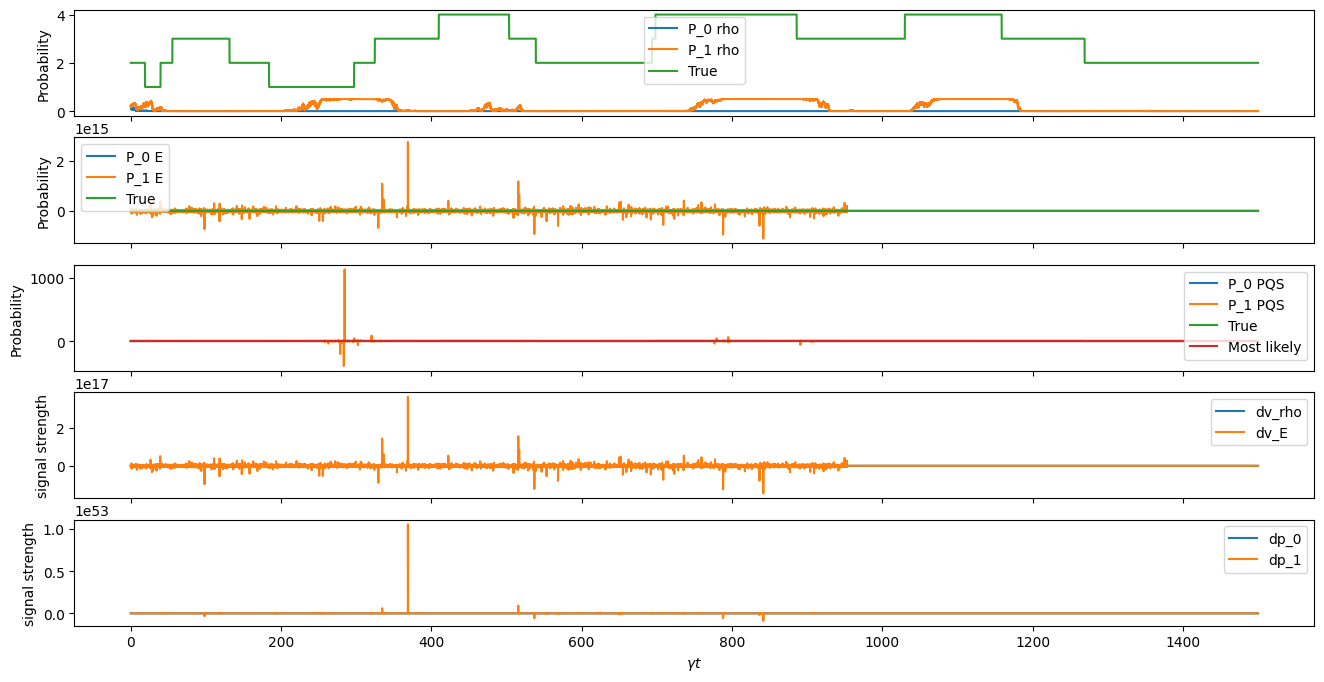

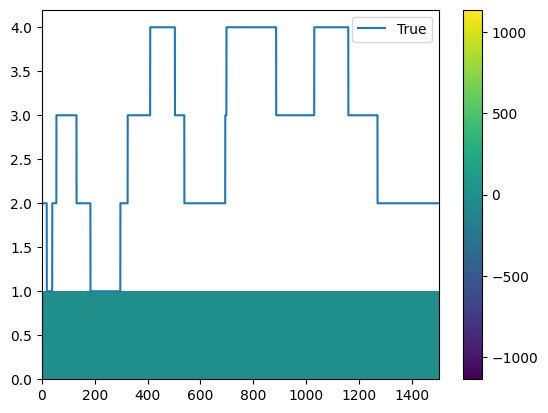

In [88]:
def plot_estimate(estimate_signal, True_signal):
    #fig, ax = plt.subplots(figsize=(16, 8))

    c = plt.imshow(estimate_signal.T, aspect='auto', extent=[0, times_gamma[-1], 0, 1], origin='lower', cmap='viridis')
    plt.plot(times_gamma, True_signal, label='True')
    #ax.set_xlabel('$\gamma t$')
    plt.legend()
    plt.colorbar(c)

print(np.shape(PQS_estimater.P_n_PQS))

fig, ax = plt.subplots(5, 1, figsize=(16, 8), sharex=True)

P_most_likely = np.argmax(PQS_estimater.P_n_PQS, axis=1)

#PQS_estimater.viterbi(r_HMM_jump, np.ones(N_states)/ N_states, PQS_estimater.P_n_PQS)
#viterbi_path = PQS_estimater.viterbi_states


ax[0].plot(times_gamma, PQS_estimater.P_n_rho[:, 0], label='P_0 rho')
ax[0].plot(times_gamma, PQS_estimater.P_n_rho[:, 1], label='P_1 rho')
ax[0].plot(times_gamma, B_state_new, label='True')  
ax[1].plot(times_gamma, PQS_estimater.P_n_E[:, 0], label='P_0 E')
ax[1].plot(times_gamma, PQS_estimater.P_n_E[:, 1], label='P_1 E')
ax[1].plot(times_gamma, B_state_new, label='True')  
ax[2].plot(times_gamma, PQS_estimater.P_n_PQS[:, 0], label='P_0 PQS')
ax[2].plot(times_gamma, PQS_estimater.P_n_PQS[:, 1], label='P_1 PQS')
ax[2].plot(times_gamma, B_state_new, label='True')  
ax[2].plot(times_gamma, P_most_likely, label='Most likely')
#ax[2].plot(times_gamma, viterbi_path, label='Viterbi')
ax[3].plot(times_gamma, PQS_estimater.dv_rho[0], label='dv_rho')
ax[3].plot(times_gamma, PQS_estimater.dv_E[0], label='dv_E')
#ax[3].plot(times_gamma, PQS_estimater.detection_record[0], label='detection record')
ax[4].plot(times_gamma, PQS_estimater.dp_0, label='dp_0')
ax[4].plot(times_gamma, PQS_estimater.dp_1, label='dp_1')
#ax[1].plot(times_gamma[10:], PQS_estimater.expectation[0][10:]*dt, label='estimator c_out')
#ax[1].plot(times, PQS_estimater.expectation[1]*dt, label='estimator n')
#ax[1].plot(times_gamma[10:], PQS.expectation[0][10:] * dt, label='True')
#ax[1].plot(times_gamma[10:], PQS_estimater.expectation[2][10:] * dt / PQS_estimater.P_n[:, 0][10:], label='c_out_0 expectation')
#ax[1].plot(times_gamma[10:], PQS_estimater.expectation[3][10:] * dt / PQS_estimater.P_n[:, 1][10:], label='c_out_1 expectation')
#ax[0].plot(times, stocastic_solution.expect[0], label='Qutip')
#ax[0].plot(times[1:], np.array(stocastic_solution.measurement).mean(axis=0)[0, :].real, label='Detection record qutip')
ax[4].set_xlabel('$\gamma t$')
#ax[1].set_ylim(0, 1)
ax[0].set_ylabel('Probability')
ax[1].set_ylabel('Probability')
ax[2].set_ylabel('Probability')
ax[3].set_ylabel('signal strength')
ax[4].set_ylabel('signal strength')



#ax[0].set_ylabel('Expectation value of c_out')

#ax[2].plot(times_gamma, Delta_n, label='Signal')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()

plt.show()

plot_estimate(PQS_estimater.P_n_PQS.real, B_state_new)

In [89]:
print(beta)

1.4142135623730951


In [90]:
print(np.mean(PQS_estimater.dv_rho[0]), np.mean(PQS_estimater.dv_E[0]))
print(np.mean(PQS_estimater.dv_rho[0]) - np.mean(PQS_estimater.dv_E[0]))

-0.00014866705589973203 234940284270.52847
-234940284270.52863


In [91]:
from operator import add

a = [1, 2, 3, 4, 5]
b = [1, 2, 3, 4, 5]
c = list(map(add, a, b) )

print(c)



[2, 4, 6, 8, 10]
